In [27]:
source_name=input('Enter Source Name (format: IC_348): ')

Enter Source Name (format: IC_348): NGC_2316


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import asyncio
import nest_asyncio
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import linear_sum_assignment
from math import radians, cos, sin, sqrt
import math
import os

In [29]:
NUM_ARMS = 8
FOCAL_PLANE_RADIUS = 6
ARM_RADIUS = 6.5
THETA_STEP = 360 / NUM_ARMS
MIN_SAFE_DISTANCE = 0.3
pickup_arm_centers = [(i * THETA_STEP, ARM_RADIUS) for i in range(NUM_ARMS)]
PARKED_RADIUS = 0.25
FIXED_END_RADIUS = 6.5

In [30]:
def convert_grouped_targets_to_polar(grouped_yso_path, groups_summary_path):
    grouped_df = pd.read_csv(grouped_yso_path)
    summary_df = pd.read_csv(groups_summary_path)
    grouped_polar_targets = {}
    for _, group_row in summary_df.iterrows():
        group_id = int(group_row['Group'])
        origin_coord = SkyCoord(group_row['RA_center'], group_row['DEC_center'], unit=(u.deg, u.deg))
        origin_ra_hms = origin_coord.ra.to_string(unit=u.hour, sep=':')
        origin_dec_dms = origin_coord.dec.to_string(unit=u.deg, sep=':', alwayssign=True)
        median_jmag = group_row['Median_Jmag']
        group_targets = grouped_df[grouped_df['Group'] == group_id]
        polar_targets = []

        for _, row in group_targets.iterrows():
            target_coord = SkyCoord(row['RA_deg'], row['DEC_deg'], unit=(u.deg, u.deg))
            sep = origin_coord.separation(target_coord).arcmin
            pa = origin_coord.position_angle(target_coord).deg % 360
            offset_arcmin = row.get('offset_arcmin', None)

            if offset_arcmin is not None:
                if abs(sep - offset_arcmin) > 0.05:
                    print(f" Warning: Group {group_id} Target mismatch: Calculated={sep:.3f} arcmin, Offset_Arcmin={offset_arcmin:.3f} arcmin")
            polar_targets.append((pa, sep))

        if polar_targets:
            grouped_polar_targets[group_id] = polar_targets

    return grouped_polar_targets

In [31]:
def polar_to_cartesian(theta_deg, r):
    theta_rad = radians(theta_deg)
    return r * cos(theta_rad), r * sin(theta_rad)
def euclidean_distance(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [32]:
def adjust_distances(targets):
    adjusted_targets = []
    for i, (theta_i, r_i) in enumerate(targets):
        is_safe = True
        for j, (theta_j, r_j) in enumerate(targets):
            if i != j:
                distance = sqrt(r_i**2 + r_j**2 - 2 * r_i * r_j * cos(radians(theta_i - theta_j)))
                if distance < MIN_SAFE_DISTANCE:
                    is_safe = False
                    break
        if is_safe:
            adjusted_targets.append((theta_i, r_i))
        else:
            print(f"Target {i + 1} adjusted due to proximity.")
    return adjusted_targets

In [33]:
def assign_targets_to_positioners(targets):
    assignments = []
    targets = sorted(targets, key=lambda x: x[0])
    for i in range(NUM_ARMS):
        assignments.append((pickup_arm_centers[i][0], targets[i]))
    return assignments

In [34]:
def assign_targets_with_parking(grouped_polar_targets):
    results = {}
    arm_cartesian = [polar_to_cartesian(theta, ARM_RADIUS) for theta, _ in pickup_arm_centers]

    for group_id, targets in grouped_polar_targets.items():
        adjusted_targets = adjust_distances(targets)
        num_targets = len(adjusted_targets)
        target_cartesian = [polar_to_cartesian(theta, r) for theta, r in adjusted_targets]
        arm_to_target = {}
        assigned_arms = []
        
        cost_matrix = np.zeros((NUM_ARMS, num_targets))
        for i in range(NUM_ARMS):
            for j in range(num_targets):
                cost_matrix[i][j]= euclidean_distance(arm_cartesian[i], target_cartesian[j])

        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        for arm_idx, tgt_idx in zip(row_ind, col_ind):
            assigned_arms.append(arm_idx)
            arm_to_target[arm_idx] = adjusted_targets[tgt_idx]
        unused_arms = [a for a in range(NUM_ARMS) if a not in assigned_arms]
        for arm in unused_arms:
            arm_to_target[arm] = (pickup_arm_centers[arm][0], FOCAL_PLANE_RADIUS)
        results[group_id] = { "assignments": arm_to_target }
    return results

In [35]:
async def move_arm(index, start, end, results):
    theta_start, r_start = start
    theta_end, r_end = end
    steps = 100
    theta_values = np.linspace(theta_start, theta_end, steps)
    r_values = np.linspace(r_start, r_end, steps)

    print(f"Arm {index + 1} moving from {start} to {end}...")
    for theta, r in zip(theta_values, r_values):
        results[index] = (theta % 360, r)
        await asyncio.sleep(0.05)
    print(f"Arm {index + 1} reached {end}.")

In [36]:
async def arrange_arms_sequential(assignments):
    results = [(theta, PARKED_RADIUS) for theta, _ in pickup_arm_centers]
    arms_by_distance = sorted(assignments.items(), key=lambda x: x[1][1], reverse=True)
    for arm_index, target in arms_by_distance:
        await move_arm(arm_index, (pickup_arm_centers[arm_index][0], PARKED_RADIUS), target, results)
    return results

In [37]:
def plot_positions(initial, final, ra_center_hms, dec_center_dms, median_jmag, group_id=None):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
    ax.set_title(f"Group {group_id}: RA={ra_center_hms} DEC={dec_center_dms} Median Jmag={median_jmag:.2f}", va='bottom')
    used_arm_indices = [i for i, (_, r) in enumerate(final) if r <= ARM_RADIUS]
    final_positions = {}
    for i, pos in enumerate(final):
        if isinstance(pos, (list, tuple, np.ndarray)):
            angle, radius = float(pos[0]), float(pos[1])
        else:
            angle, radius = 0.0, 0.0
        final_positions[i] = (angle, radius)
        
    for i, (theta_init, _) in enumerate(initial):
        theta_final, r_final = final_positions.get(i, (theta_init, PARKED_RADIUS))
        theta_rad = np.radians(theta_final)        
        ax.plot([theta_rad, theta_rad], [PARKED_RADIUS, r_final], linestyle=':', linewidth=1.5, color='gray')
        is_active = i in used_arm_indices
        color = 'tab:red' if is_active else 'black'
        label = ''
        ax.plot([np.radians(theta_init), theta_rad], [FIXED_END_RADIUS, r_final], color=color, linewidth=2, marker='o', label=label)
        ax.text(theta_rad, r_final + 0.6, f"A{i+1}", fontsize=9, ha='center', va='center')

        if label:
            legend_flags[label] = True
    
    fov = np.linspace(0, 2 * np.pi, 360)
    r_boundary = np.full_like(fov, FOCAL_PLANE_RADIUS)
    ax.plot(fov, r_boundary, 'k--', linewidth=2.5, alpha=0.5)
    ax.set_rmax(FOCAL_PLANE_RADIUS + 2)
    ax.set_rticks(np.arange(0, FOCAL_PLANE_RADIUS + 2, 1))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(1)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [38]:
async def run_simulation(grouped_yso_path, groups_summary_path):
    grouped_targets = convert_grouped_targets_to_polar(grouped_yso_path, groups_summary_path)
    assigned = assign_targets_with_parking(grouped_targets)
    summary_df = pd.read_csv(groups_summary_path)
    group_row = summary_df[summary_df['Group'] == group_id].iloc[0]
    median_jmag = group_row['Median_Jmag']
    origin_coord = SkyCoord(group_row['RA_center'], group_row['DEC_center'], unit=(u.deg, u.deg))
    origin_ra_hms = origin_coord.ra.to_string(unit=u.hour, sep=':')
    origin_dec_dms = origin_coord.dec.to_string(unit=u.deg, sep=':', alwayssign=True)
    assignments = assigned[group_id]['assignments']
    final_positions = await arrange_arms_sequential(assignments)
    plot_positions(pickup_arm_centers, final_positions, origin_ra_hms, origin_dec_dms, median_jmag, group_id)
    results_list = []
    for i, (theta, r) in enumerate(final_positions):
        results_list.append({
            "Group": group_id,
            "Arm_ID": f"A{i+1}",
            "Angle_deg": round(theta, 2),
            "Radius_arcmin": round(r, 2),
            "Median_Jmag": median_jmag
        })
    csv_output_path = os.path.join(os.getcwd(), f"arm_positions_{source_name}.csv")
    df_out = pd.DataFrame(results_list)
    print(f" Arm position data saved to: {csv_output_path}")

Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 2 moving from (45.0, 0.25) to (45.0, 6)...
Arm 2 reached (45.0, 6).
Arm 3 moving from (90.0, 0.25) to (90.0, 6)...
Arm 3 reached (90.0, 6).
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 7 moving from (270.0, 0.25) to (270.0, 6)...
Arm 7 reached (270.0, 6).
Arm 8 moving from (315.0, 0.25) to (315.0, 6)...
Arm 8 reached (315.0, 6).
Arm 6 moving from (225.0, 0.25) to (241.0110925147777, 1.0651145330528362)...
Arm 6 reached (241.0110925147777, 1.0651145330528362).


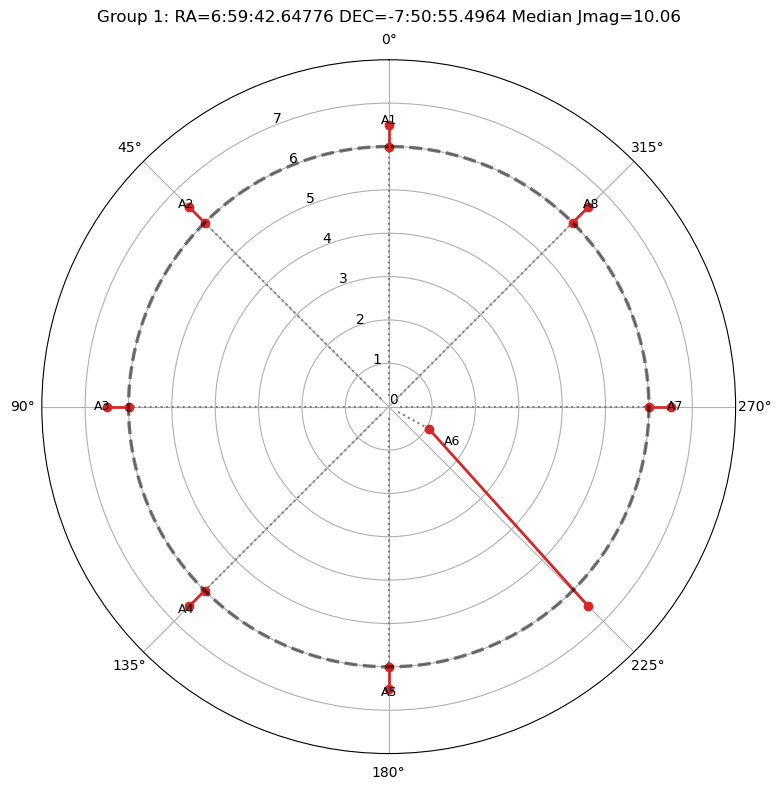

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 2 moving from (45.0, 0.25) to (45.0, 6)...
Arm 2 reached (45.0, 6).
Arm 3 moving from (90.0, 0.25) to (90.0, 6)...
Arm 3 reached (90.0, 6).
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 8 moving from (315.0, 0.25) to (315.0, 6)...
Arm 8 reached (315.0, 6).
Arm 7 moving from (270.0, 0.25) to (267.8629668125623, 3.3237456190102246)...
Arm 7 reached (267.8629668125623, 3.3237456190102246).


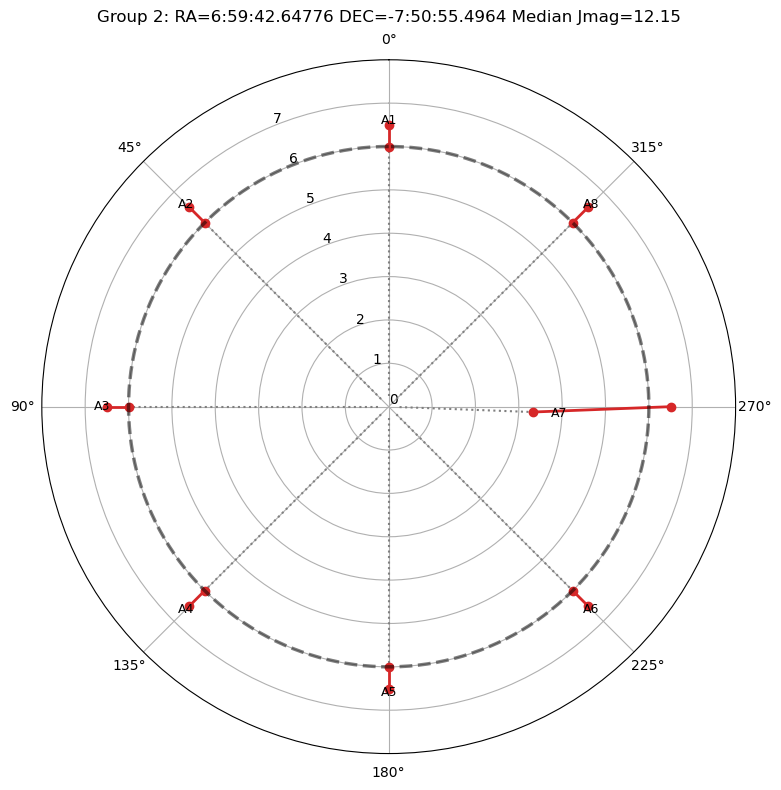

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 8 moving from (315.0, 0.25) to (315.0, 6)...
Arm 8 reached (315.0, 6).
Arm 2 moving from (45.0, 0.25) to (72.18667495475025, 3.7115651220808537)...
Arm 2 reached (72.18667495475025, 3.7115651220808537).
Arm 7 moving from (270.0, 0.25) to (289.12941274167275, 2.7589738834007798)...
Arm 7 reached (289.12941274167275, 2.7589738834007798).
Arm 3 moving from (90.0, 0.25) to (90.0021917636884, 1.9079572525701638)...
Arm 3 reached (90.0021917636884, 1.9079572525701638).


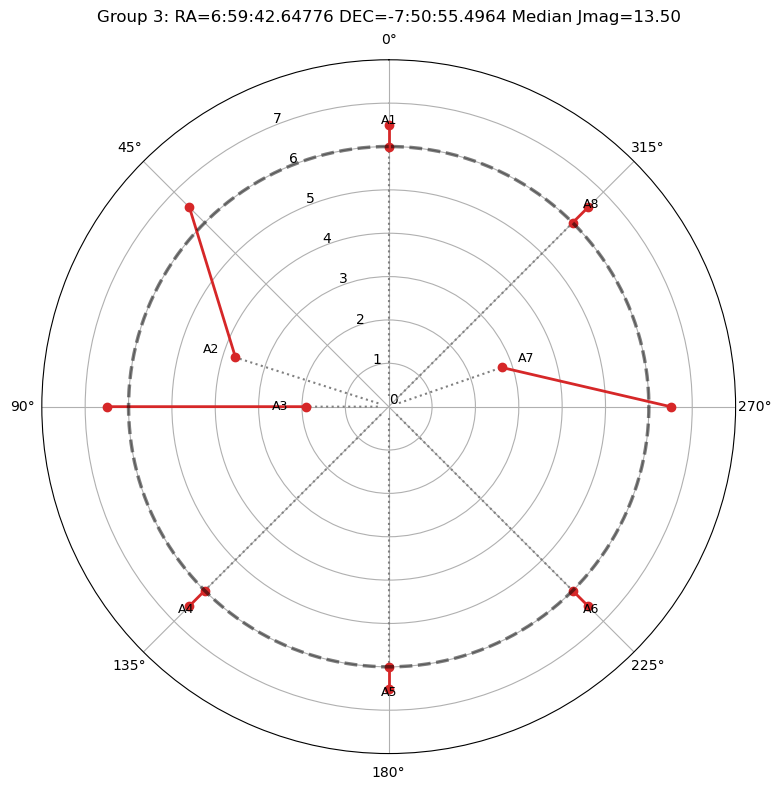

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 2 moving from (45.0, 0.25) to (45.0, 6)...
Arm 2 reached (45.0, 6).
Arm 3 moving from (90.0, 0.25) to (90.0, 6)...
Arm 3 reached (90.0, 6).
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 8 moving from (315.0, 0.25) to (315.0, 6)...
Arm 8 reached (315.0, 6).
Arm 7 moving from (270.0, 0.25) to (251.20996391565168, 0.37852273117476987)...
Arm 7 reached (251.20996391565168, 0.37852273117476987).


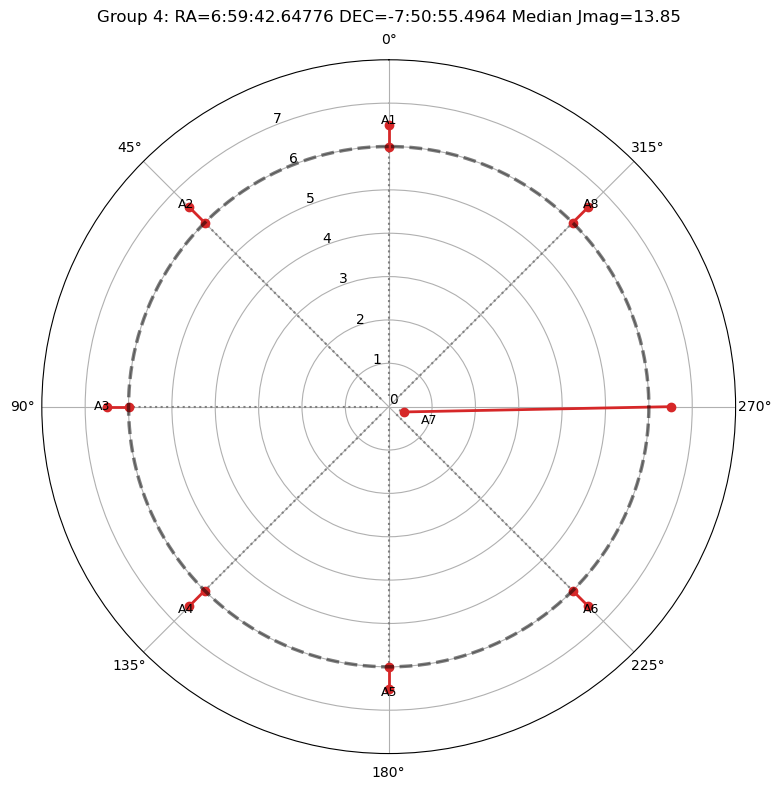

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 2 moving from (45.0, 0.25) to (45.0, 6)...
Arm 2 reached (45.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 3 moving from (90.0, 0.25) to (80.6295769272804, 2.5603778874288783)...
Arm 3 reached (80.6295769272804, 2.5603778874288783).
Arm 7 moving from (270.0, 0.25) to (253.49231324313942, 2.0333219503872426)...
Arm 7 reached (253.49231324313942, 2.0333219503872426).
Arm 8 moving from (315.0, 0.25) to (293.7826051408141, 1.045166494549651)...
Arm 8 reached (293.7826051408141, 1.045166494549651).
Arm 4 moving from (135.0, 0.25) to (113.55902354535162, 1.043345108763795)...
Arm 4 reached (113.55902354535162, 1.043345108763795).


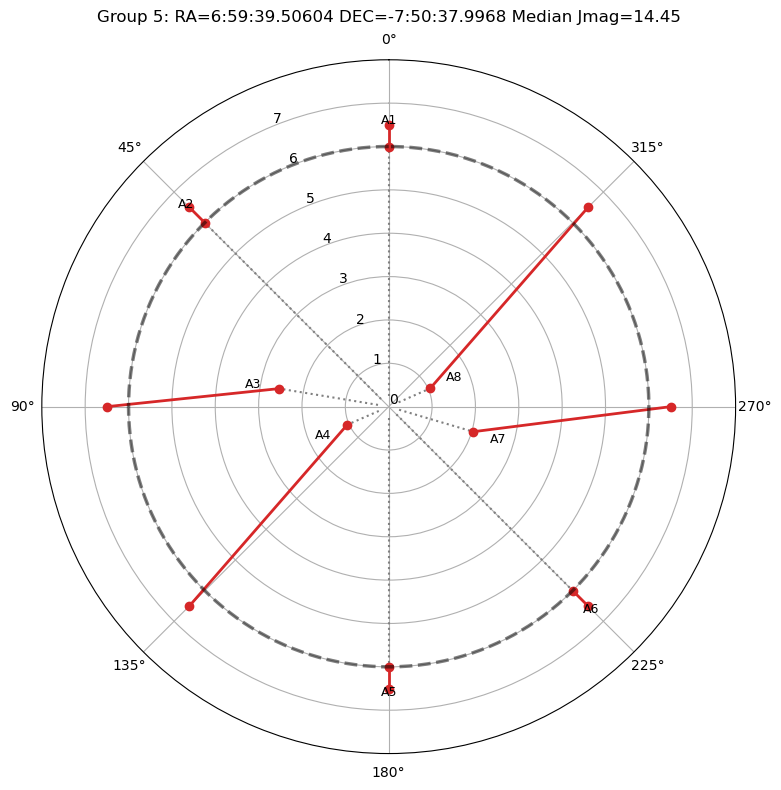

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 2 moving from (45.0, 0.25) to (45.0, 6)...
Arm 2 reached (45.0, 6).
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 7 moving from (270.0, 0.25) to (270.0, 6)...
Arm 7 reached (270.0, 6).
Arm 3 moving from (90.0, 0.25) to (80.89781476214355, 2.4421863582523584)...
Arm 3 reached (80.89781476214355, 2.4421863582523584).
Arm 8 moving from (315.0, 0.25) to (292.90250198763414, 2.3082530976692803)...
Arm 8 reached (292.90250198763414, 2.3082530976692803).
Arm 5 moving from (180.0, 0.25) to (200.7803221295777, 0.3471213904765689)...
Arm 5 reached (200.7803221295777, 0.3471213904765689).


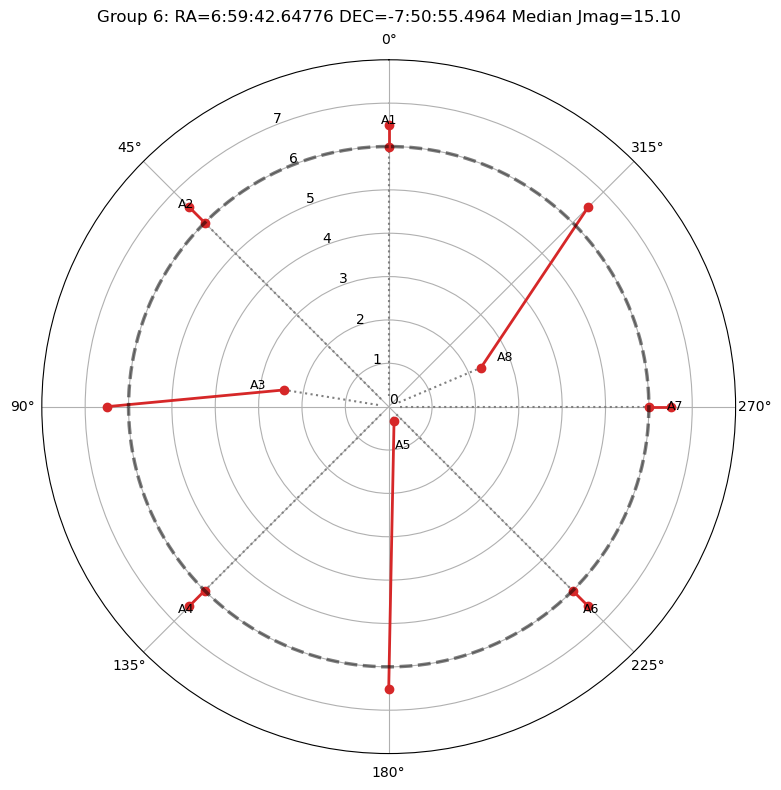

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 7 moving from (270.0, 0.25) to (268.68310871481066, 2.9183921904658057)...
Arm 7 reached (268.68310871481066, 2.9183921904658057).
Arm 3 moving from (90.0, 0.25) to (92.04457052482114, 2.7556211878236123)...
Arm 3 reached (92.04457052482114, 2.7556211878236123).
Arm 8 moving from (315.0, 0.25) to (312.34398396508846, 1.616869891252495)...
Arm 8 reached (312.34398396508846, 1.616869891252495).
Arm 6 moving from (225.0, 0.25) to (268.01065884803825, 1.4738758310935545)...
Arm 6 reached (268.01065884803825, 1.4738758310935545).
Arm 4 moving from (135.0, 0.25) to (108.68945016629142, 1.417545194413022)...
Arm 4 reached (108.68945016629142, 1.417545194413022).
Arm 2 moving from (45.0, 0.25) to (103.60650010166556, 0.38257964837044983)...
Arm 2 reach

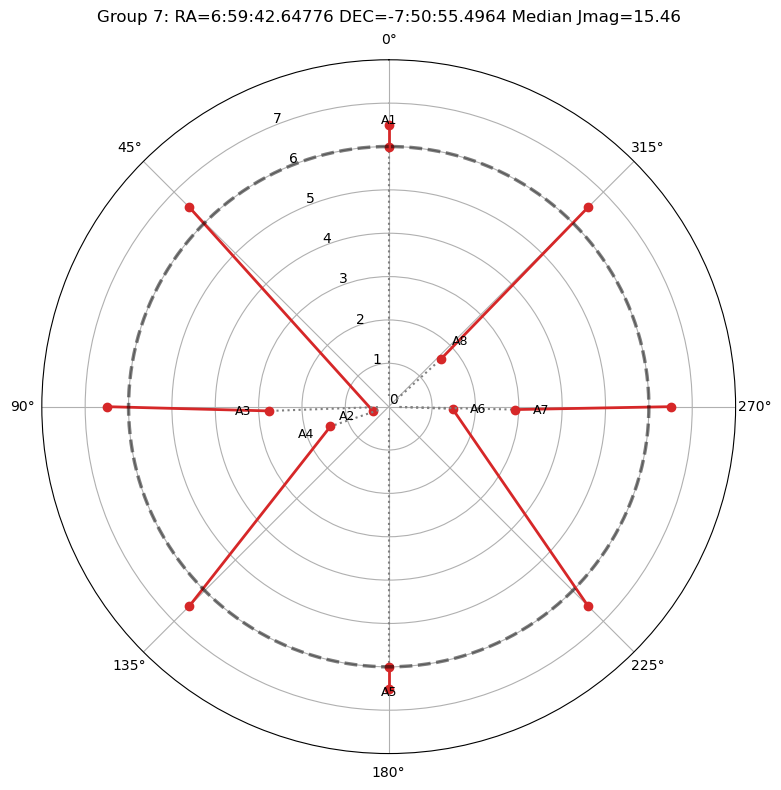

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 2 moving from (45.0, 0.25) to (45.0, 6)...
Arm 2 reached (45.0, 6).
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 7 moving from (270.0, 0.25) to (270.0, 6)...
Arm 7 reached (270.0, 6).
Arm 8 moving from (315.0, 0.25) to (315.0, 6)...
Arm 8 reached (315.0, 6).
Arm 3 moving from (90.0, 0.25) to (74.94296454409027, 3.3322465894708815)...
Arm 3 reached (74.94296454409027, 3.3322465894708815).


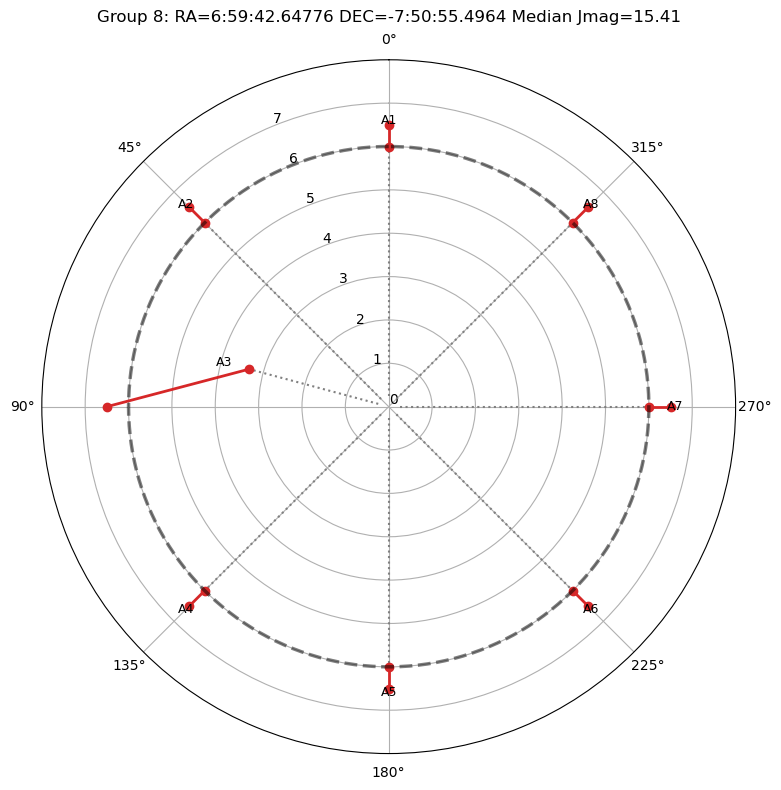

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 2 moving from (45.0, 0.25) to (45.0, 6)...
Arm 2 reached (45.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 7 moving from (270.0, 0.25) to (259.18884555915594, 2.610253268354653)...
Arm 7 reached (259.18884555915594, 2.610253268354653).
Arm 8 moving from (315.0, 0.25) to (313.56740309280593, 1.7991476863164515)...
Arm 8 reached (313.56740309280593, 1.7991476863164515).
Arm 4 moving from (135.0, 0.25) to (116.71249199091977, 1.6867237395601014)...
Arm 4 reached (116.71249199091977, 1.6867237395601014).
Arm 6 moving from (225.0, 0.25) to (285.64702791077343, 0.743426324683165)...
Arm 6 reached (285.64702791077343, 0.743426324683165).
Arm 3 moving from (90.0, 0.25) to (68.29393596589078, 0.3306197944861999)...
Arm 3 reached (68.29393596589078, 0.3306197944861999).


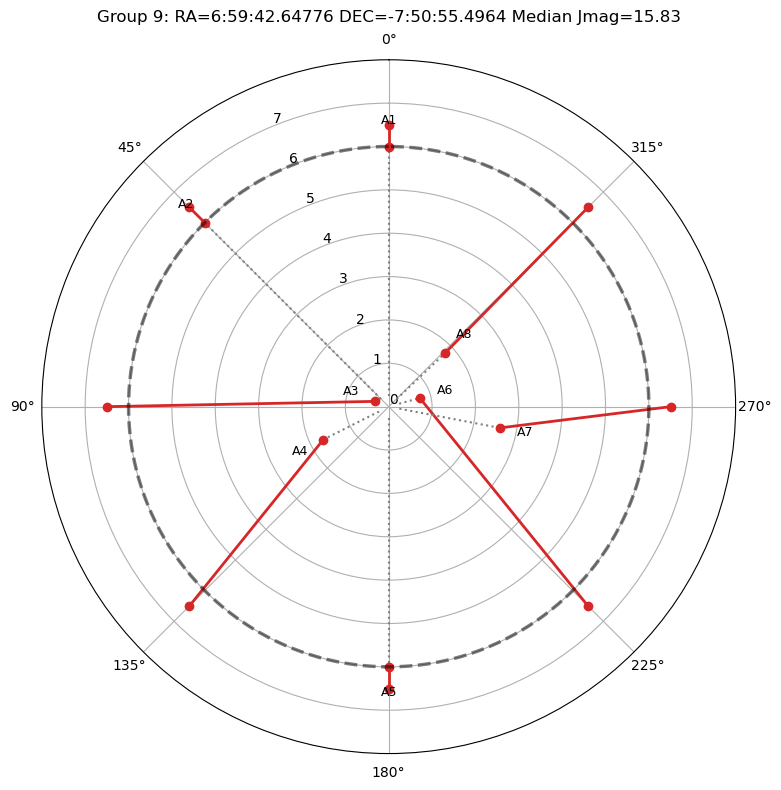

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 2 moving from (45.0, 0.25) to (45.0, 6)...
Arm 2 reached (45.0, 6).
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 7 moving from (270.0, 0.25) to (270.0, 6)...
Arm 7 reached (270.0, 6).
Arm 8 moving from (315.0, 0.25) to (315.0, 6)...
Arm 8 reached (315.0, 6).
Arm 3 moving from (90.0, 0.25) to (107.30909220458199, 2.0037665435965613)...
Arm 3 reached (107.30909220458199, 2.0037665435965613).
Arm 5 moving from (180.0, 0.25) to (180.0, 1.0510200000001553)...
Arm 5 reached (180.0, 1.0510200000001553).
Arm 1 moving from (0.0, 0.25) to (343.4065067819865, 0.5394864299565383)...
Arm 1 reached (343.4065067819865, 0.5394864299565383).


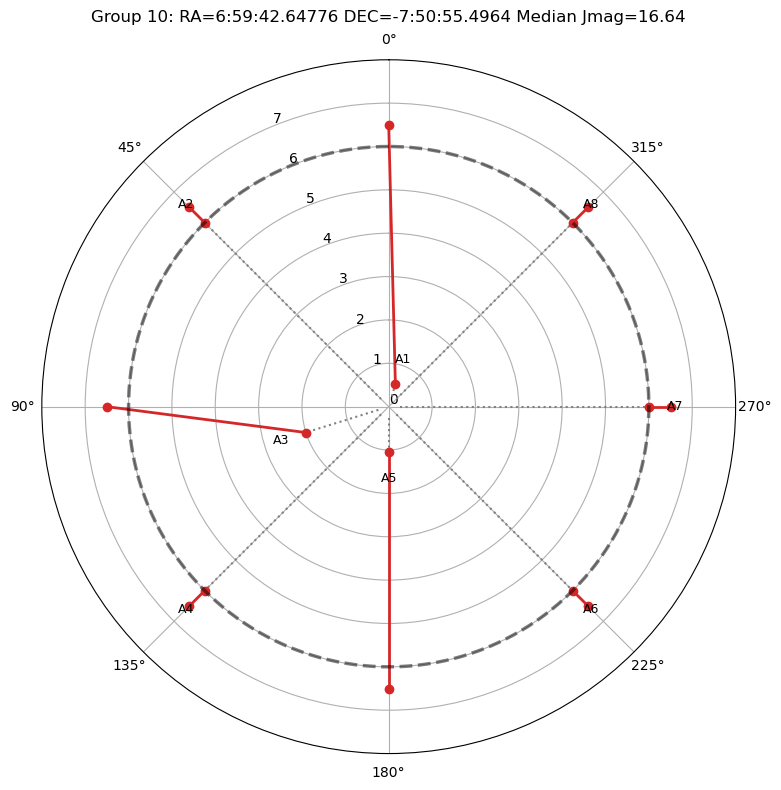

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 3 moving from (90.0, 0.25) to (90.0, 6)...
Arm 3 reached (90.0, 6).
Arm 4 moving from (135.0, 0.25) to (135.0, 6)...
Arm 4 reached (135.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 7 moving from (270.0, 0.25) to (270.0, 6)...
Arm 7 reached (270.0, 6).
Arm 8 moving from (315.0, 0.25) to (315.0, 6)...
Arm 8 reached (315.0, 6).
Arm 2 moving from (45.0, 0.25) to (67.19386606191719, 3.112927273563022)...
Arm 2 reached (67.19386606191719, 3.112927273563022).


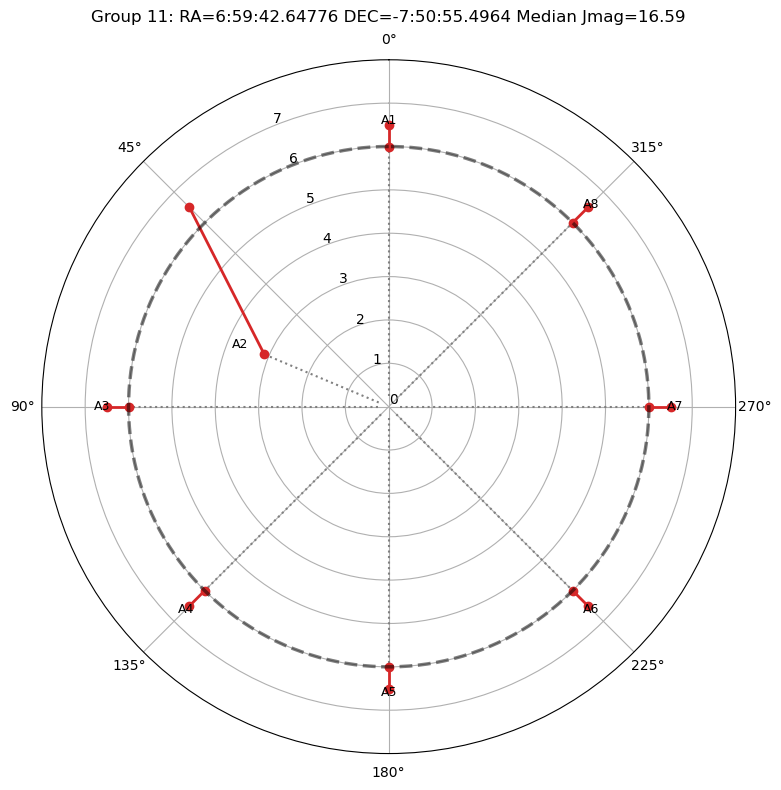

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv
Arm 1 moving from (0.0, 0.25) to (0.0, 6)...
Arm 1 reached (0.0, 6).
Arm 5 moving from (180.0, 0.25) to (180.0, 6)...
Arm 5 reached (180.0, 6).
Arm 6 moving from (225.0, 0.25) to (225.0, 6)...
Arm 6 reached (225.0, 6).
Arm 8 moving from (315.0, 0.25) to (315.0, 6)...
Arm 8 reached (315.0, 6).
Arm 2 moving from (45.0, 0.25) to (69.98876772199145, 3.0320987176306993)...
Arm 2 reached (69.98876772199145, 3.0320987176306993).
Arm 7 moving from (270.0, 0.25) to (276.3594994250954, 2.9322037503219285)...
Arm 7 reached (276.3594994250954, 2.9322037503219285).
Arm 3 moving from (90.0, 0.25) to (86.80731565212709, 2.284189983910278)...
Arm 3 reached (86.80731565212709, 2.284189983910278).
Arm 4 moving from (135.0, 0.25) to (100.2360242641591, 1.1589308617144318)...
Arm 4 reached (100.2360242641591, 1.1589308617144318).


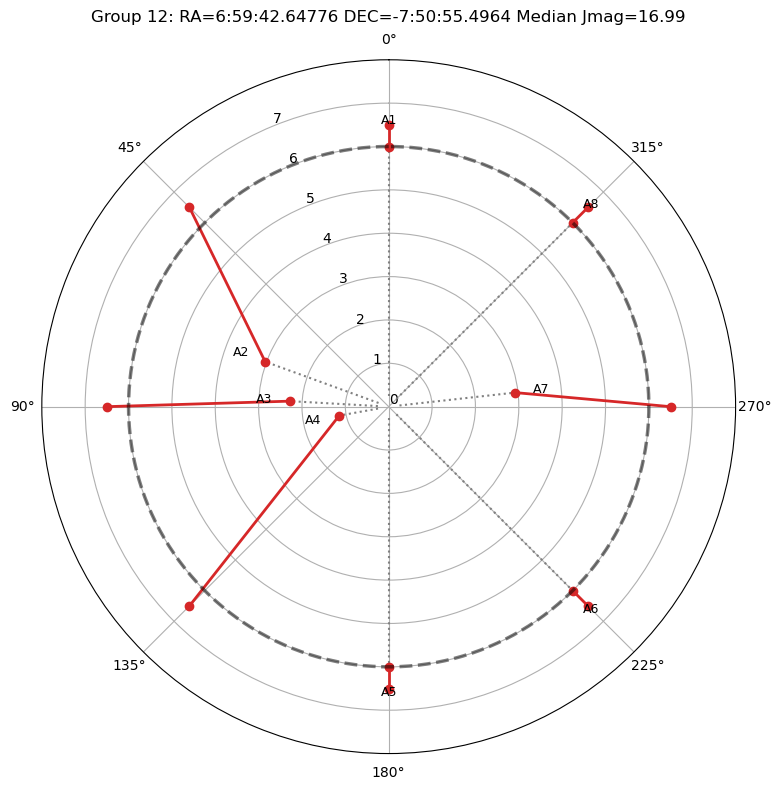

 Arm position data saved to: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\arm_positions_NGC_2316.csv


In [39]:
nest_asyncio.apply()
grouped_yso_path = fr"C:\Users\kgokh\Downloads\TAMOONS NEW FILE\grouped_ysos_{source_name}.csv"
groups_summary_path = fr"C:\Users\kgokh\Downloads\TAMOONS NEW FILE\group_summary_{source_name}.csv"
grouped_targets = convert_grouped_targets_to_polar(grouped_yso_path, groups_summary_path)
summary_df = pd.read_csv(groups_summary_path)
for group_id in grouped_targets.keys():
    group_row = summary_df[summary_df['Group'] == group_id].iloc[0]
    median_jmag = group_row['Median_Jmag']
    await run_simulation(grouped_yso_path, groups_summary_path)